Aperçu des données après correction du séparateur:
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  

Informations sur les données:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643

<Figure size 1200x600 with 0 Axes>

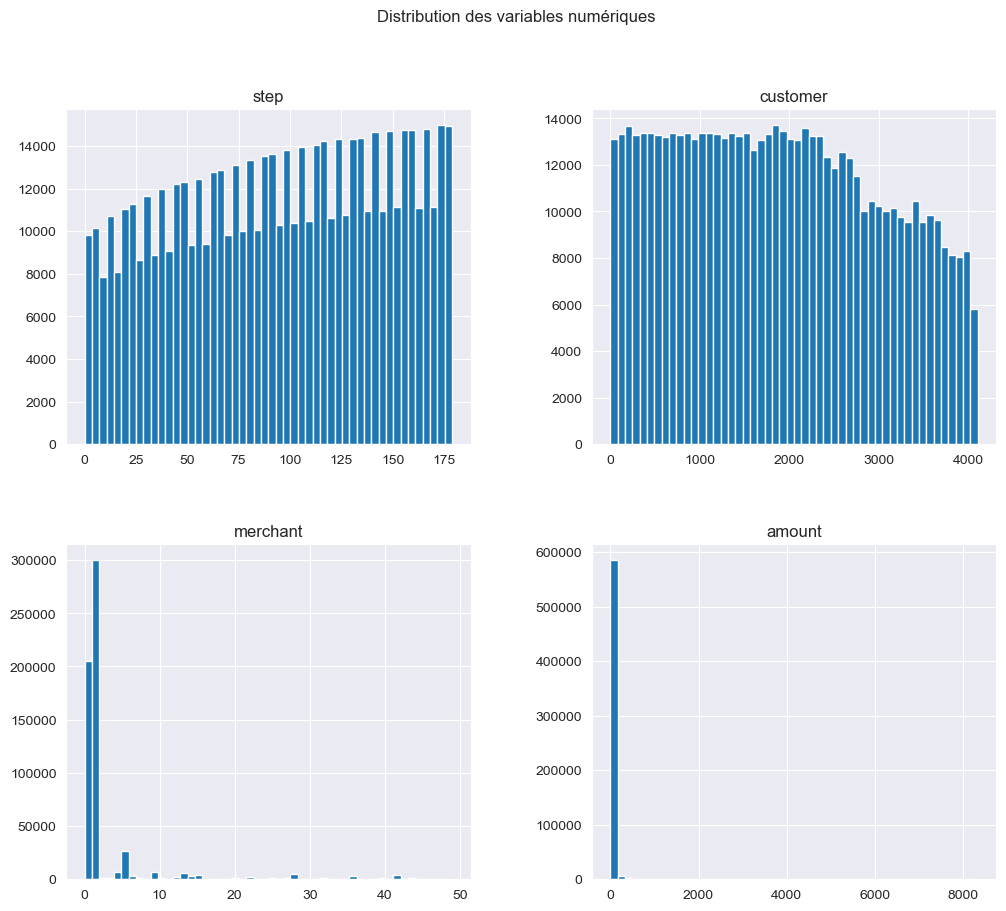

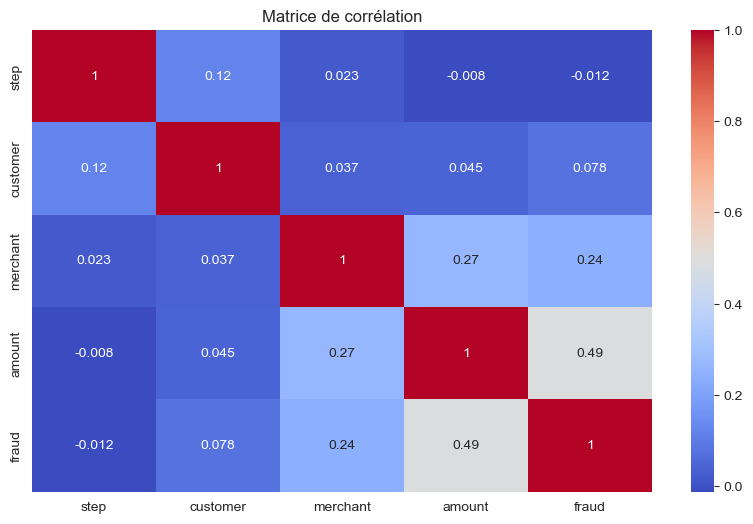


Accuracy (Random Forest): 0.9961405544484524

Matrice de Confusion (Random Forest):
[[117415     97]
 [   362   1055]]

Rapport de Classification (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117512
           1       0.92      0.74      0.82      1417

    accuracy                           1.00    118929
   macro avg       0.96      0.87      0.91    118929
weighted avg       1.00      1.00      1.00    118929



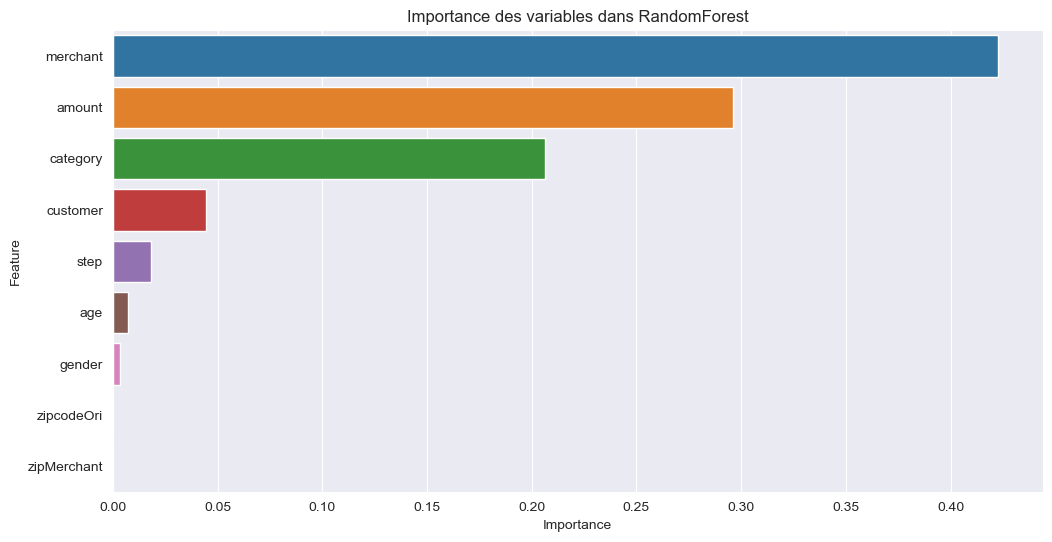

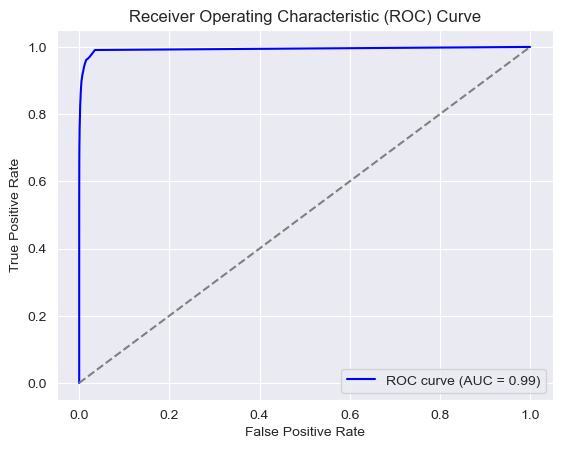

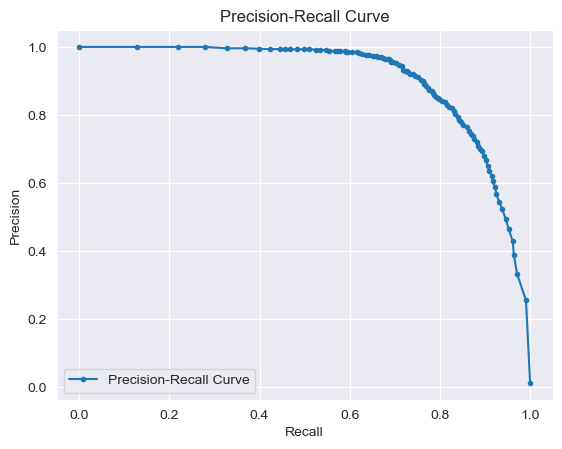

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve

# Chargement des données avec le bon séparateur
chunk_size = 100000
chunks = pd.read_csv('data/Data_Project_cdsd3.csv', sep=';', chunksize=chunk_size, low_memory=False)
data = pd.concat(chunks)

# Vérification après chargement
print("Aperçu des données après correction du séparateur:")
print(data.head())
print("\nInformations sur les données:")
print(data.info())

# Suppression des doublons
data = data.drop_duplicates()

# Gestion des valeurs manquantes
data.fillna(data.mean(numeric_only=True), inplace=True)

# Détection de la colonne cible
fraud_col = 'fraud' if 'fraud' in data.columns else None
if fraud_col:
    print(f"Utilisation de la colonne cible: {fraud_col}")

    # Vérifier si fraud a été normalisée
    if data[fraud_col].nunique() > 10:
        print("Attention: La colonne fraud semble être continue au lieu de binaire. Tentative de correction...")
        data[fraud_col] = (data[fraud_col] > data[fraud_col].median()).astype(int)

    print("Valeurs uniques de la variable cible:", data[fraud_col].unique())

# Encodage des variables catégorielles
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    if data[col].nunique() < 50:  # Si peu de valeurs uniques, on utilise LabelEncoder
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
    else:
        data[col] = pd.factorize(data[col])[0]  # Encodage rapide pour grandes catégories

# Sélection des colonnes numériques
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
if fraud_col in numerical_cols:
    numerical_cols.remove(fraud_col)

# Visualisation des distributions des variables
plt.figure(figsize=(12, 6))
data[numerical_cols].hist(bins=50, figsize=(12, 10))
plt.suptitle("Distribution des variables numériques")
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10, 6))
corr = data[numerical_cols + [fraud_col]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

# Normalisation des variables numériques
if numerical_cols:
    data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')
    data.dropna(subset=numerical_cols, inplace=True)
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

if fraud_col:
    X = data.drop(columns=[fraud_col])
    y = data[fraud_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle RandomForest
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    print("\nAccuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
    print("\nMatrice de Confusion (Random Forest):")
    print(confusion_matrix(y_test, y_pred_rf))
    print("\nRapport de Classification (Random Forest):")
    print(classification_report(y_test, y_pred_rf))

    # Importance des variables
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
    plt.title("Importance des variables dans RandomForest")
    plt.show()

    # Courbe ROC-AUC
    auc_score = roc_auc_score(y_test, y_prob_rf)
    fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Courbe de précision-rappel
    precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
    plt.figure()
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
else:
    print("Erreur: La colonne cible 'fraud' est introuvable.")
